# Computational astrophysics
# HW 3

In [1]:
# libraries imported 
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use('/Users/dionysisgakis/.config/matplotlib/stylelib/publication.mplstyle') # plotting style, comment out if in another computer

## Problem 1

In [4]:
import numpy as np
from scipy.spatial import cKDTree
import time

G = 1.0           # Gravitational constant (arbitrary units)
softening = 0.0001   # Softening parameter to avoid singularities
seed = 8675309    # Fixed seed for reproducibility

def random_positions(N, seed=8675309):
    rng = np.random.RandomState(seed)
    return rng.uniform(0, 100, size=(N, 3))

# a_i = Σ_{j ≠ i} [ G * (r_j - r_i) / (|r_j - r_i|^2 + ε^2)^(3/2) ]

def accelerations_directly(pos): 
    N = len(pos)
    acc = np.zeros_like(pos)
    for i in range(N):
        dx = pos - pos[i]  # Vector from particle i to all other particles
        r2 = np.sum(dx**2, axis=1) + softening**2 # Squared distance with softening (r^2 + epsilon^2)
        inv_r3 = np.where(r2 > 0, 1.0 / (r2 * np.sqrt(r2)), 0)  # Avoid self-acceleration
        acc[i] = G * np.sum(dx * inv_r3[:, np.newaxis], axis=0)
    return acc

def accelerations_kdtree(pos, cutoff_radius=10.0):
    tree = cKDTree(pos)
    acc = np.zeros_like(pos)
    for i, p in enumerate(pos):
        idxs = tree.query_ball_point(p, r=cutoff_radius)
        if i in idxs:
            idxs.remove(i)  # avoid self-interaction
        dx = pos[idxs] - p
        r2 = np.sum(dx**2, axis=1) + softening**2
        inv_r3 = 1.0 / (r2 * np.sqrt(r2))
        acc[i] = G * np.sum(dx * inv_r3[:, np.newaxis], axis=0)
    return acc

Ns = [10**3, 10**4, 10**5, 10**6] # number of particles tested
times_direct = []
times_kdtree = []

for N in Ns:
    print(f"\nN = {N}")
    pos = random_positions(N, seed=seed)

    # Direct method
    start = time.time()
    acc_direct = accelerations_directly(pos)
    times_direct.append(time.time() - start)
    print(f"Direct time: {times_direct[-1]:.2f} s")

    # KDTree method
    start = time.time()
    acc_kdtree = accelerations_kdtree(pos)
    times_kdtree.append(time.time() - start)
    print(f"KDTree time: {times_kdtree[-1]:.2f} s")

    diff = np.linalg.norm(acc_direct - acc_kdtree) / np.linalg.norm(acc_direct) * 100
    print(f"Relative difference: {diff:.2f} %")



N = 1000
Direct time: 0.05 s
KDTree time: 0.02 s
Relative difference: 31.88 %

N = 10000
Direct time: 2.53 s
KDTree time: 0.20 s
Relative difference: 89.91 %

N = 100000
Direct time: 260.42 s
KDTree time: 5.24 s
Relative difference: 93.91 %

N = 1000000


KeyboardInterrupt: 

In [2]:
# with Numba

import numpy as np
from scipy.spatial import cKDTree
import time
from numba import njit, prange
import matplotlib.pyplot as plt
import os
os.environ["OMP_DISPLAY_ENV"] = "FALSE" # don't get warnings from Numba

G = 1.0
softening = 0.0001
seed = 8675309

def random_positions(N, seed=8675309):
    rng = np.random.RandomState(seed)
    return rng.uniform(0, 100, size=(N, 3))

@njit(parallel=True)
def accelerations_directly_numba(pos): 
    N = len(pos)
    acc = np.zeros((N, 3))
    for i in prange(N):
        ax, ay, az = 0.0, 0.0, 0.0
        for j in range(N):
            if i == j:
                continue # avoid self-interaction
            dx = pos[j, 0] - pos[i, 0]
            dy = pos[j, 1] - pos[i, 1]
            dz = pos[j, 2] - pos[i, 2]
            r2 = dx*dx + dy*dy + dz*dz + softening**2
            inv_r3 = 1.0 / (r2 * np.sqrt(r2))
            ax += dx * inv_r3
            ay += dy * inv_r3
            az += dz * inv_r3
        acc[i, 0] = G * ax
        acc[i, 1] = G * ay
        acc[i, 2] = G * az
    return acc

def accelerations_kdtree(pos, cutoff_radius=10.0):
    tree = cKDTree(pos)
    acc = np.zeros_like(pos)
    for i, p in enumerate(pos):
        idxs = tree.query_ball_point(p, r=cutoff_radius)
        if i in idxs:
            idxs.remove(i)
        dx = pos[idxs] - p
        r2 = np.sum(dx**2, axis=1) + softening**2
        inv_r3 = r2**(-1.5)
        acc[i] = G * np.sum(dx * inv_r3[:, np.newaxis], axis=0)
    return acc

Ns = [10**3, 10**4, 10**5, 10**6] # number of particles tested
times_direct = []
times_kdtree = []

for N in Ns:
    print(f"\nN = {N}")
    pos = random_positions(N, seed=seed)

    # Numba-accelerated direct method
    start = time.time()
    acc_direct = accelerations_directly_numba(pos)
    times_direct.append(time.time() - start)
    print(f"Direct (Numba) time: {times_direct[-1]:.2f} s")

    # KDTree method
    start = time.time()
    acc_kdtree = accelerations_kdtree(pos)
    times_kdtree.append(time.time() - start)
    print(f"KDTree time: {times_kdtree[-1]:.2f} s")

    diff = np.linalg.norm(acc_direct - acc_kdtree) / np.linalg.norm(acc_direct) * 100
    print(f"Relative difference: {diff:.2f} %")



N = 1000


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Direct (Numba) time: 0.79 s
KDTree time: 0.02 s
Relative difference: 31.88 %

N = 10000
Direct (Numba) time: 0.05 s
KDTree time: 0.19 s
Relative difference: 89.91 %

N = 100000
Direct (Numba) time: 4.47 s
KDTree time: 5.43 s
Relative difference: 93.91 %

N = 1000000
Direct (Numba) time: 625.33 s
KDTree time: 445.10 s
Relative difference: 94.81 %


Direct method scales as $N^2$, whereas the kd tree method as $N \log N$. I selected a cutoff radius of 10 (the total side of the world cube is 100) for the kd tree, that is for each particle, only other particles within a sphere of radius 10 are considered for the calculation of the acceleration, and the rest of them are ignored. Essentially, the idea is that the contribution of distant particles is negligible, and ignoring them also saves computational time. However, accuracy is lost, and to quantify it, I calculate the norm of the relative differences of the accelerations computed using the kd tree and using the direct method (which is the accurate one). For the cutoff radius I chose, the relative difference is on the order of 90% which seems large, but when changing it there's the trade-off accuracy vs computational time. In reality, increasing the cutoff radius (or equivalently increasing the number of neighbours for which acceleration is calculated), we are technically falling back in the direct method, without using the advantages of kd tree. I also tried other techniques to gain some accuracy (particularly building an oct tree), but even that didn't run significantly faster.

I also notice some interesting features regarding the running times vs the number of particles. In general, times increase with the number of particles for the direct method, with the exception of N = 10000, for which it dropped compared to N = 1000. Times grow with the number of particles for the kd tree method as well, but in half of the cases they are larger than the respective times for the direct method (even though the kd tree method is supposed to speed things up). I attribute this fact to the scaling of $\sim N \log N$, which is roughly $\sim N$ for small N. For large numbers of N, the kd tree is the optimal way to proceed, if we achieve to maintain its underlying errors low.

In the cell above I used numba to speed up the calculations of the direct method, which indeed made the code run way faster. The original code takes too long to run for 1000000 particles, so I had to interrupt it.

## Problem 2

Simulation for bulk velcoity = 0.0 km/s using compressible done.


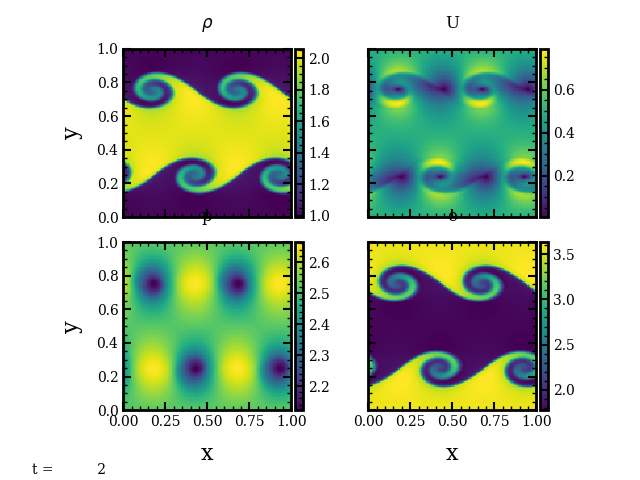

Simulation for bulk velcoity = 0.0 km/s using compressible_rk done.


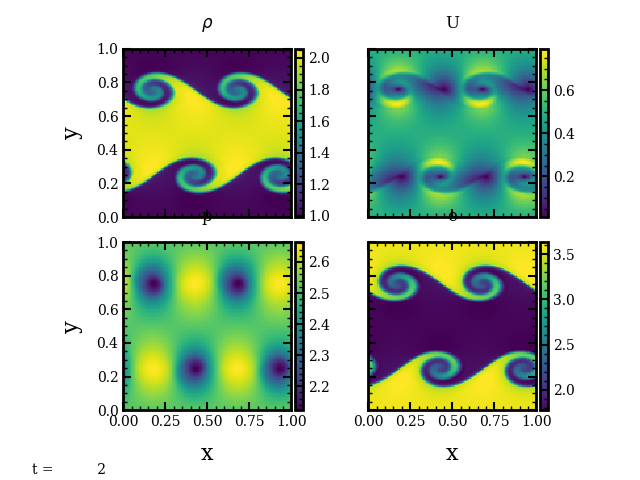

Simulation for bulk velcoity = 0.0 km/s using compressible_fv4 done.


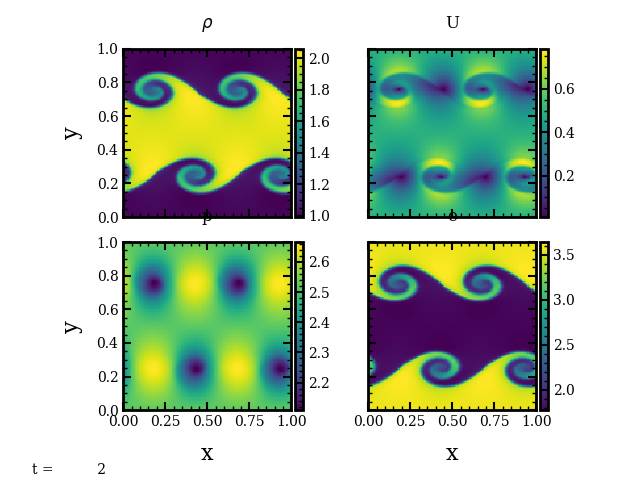

warning, key: compressible.limiter not defined
Simulation for bulk velcoity = 0.0 km/s using compressible_sdc done.


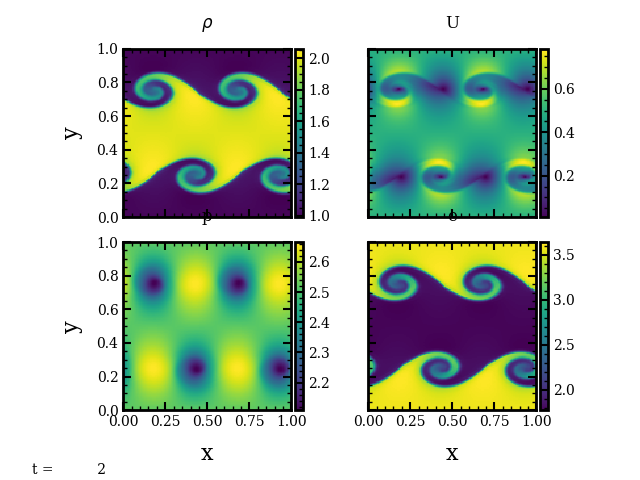

Simulation for bulk velcoity = 1.0 km/s using compressible done.


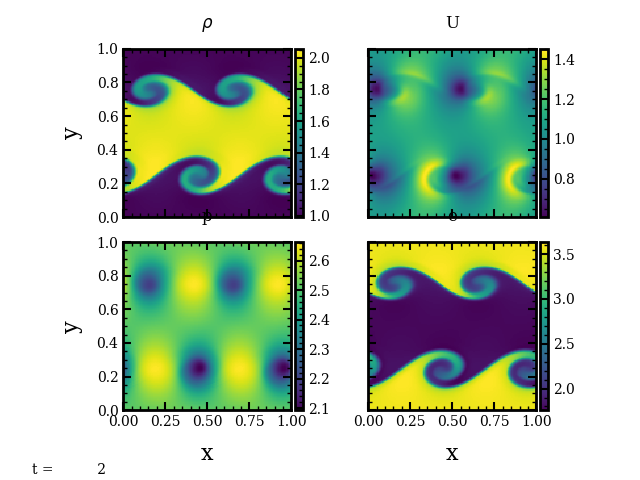

Simulation for bulk velcoity = 1.0 km/s using compressible_rk done.


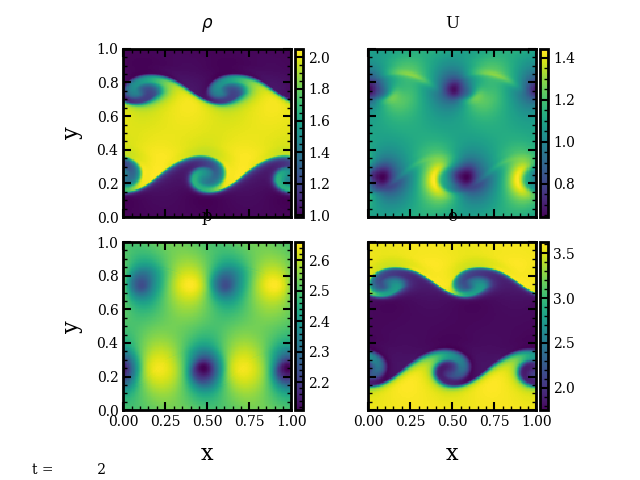

Simulation for bulk velcoity = 1.0 km/s using compressible_fv4 done.


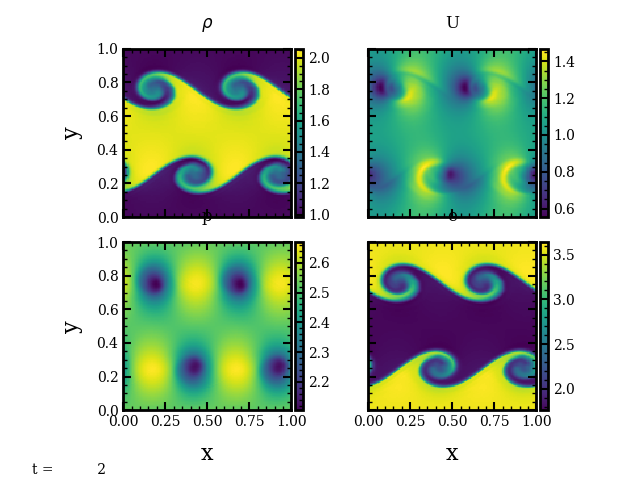

warning, key: compressible.limiter not defined
Simulation for bulk velcoity = 1.0 km/s using compressible_sdc done.


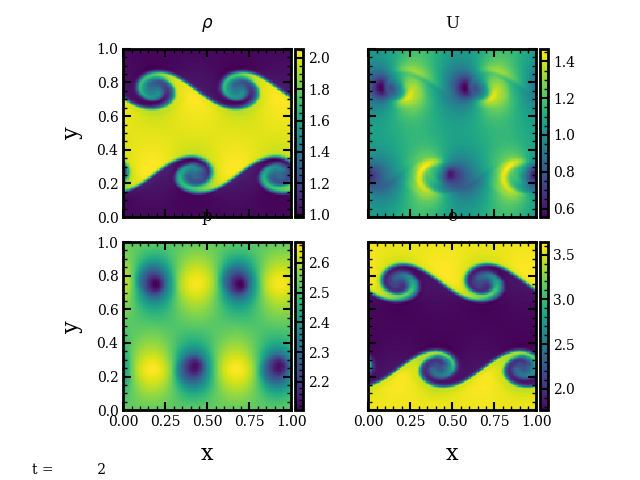

Simulation for bulk velcoity = 3.0 km/s using compressible done.


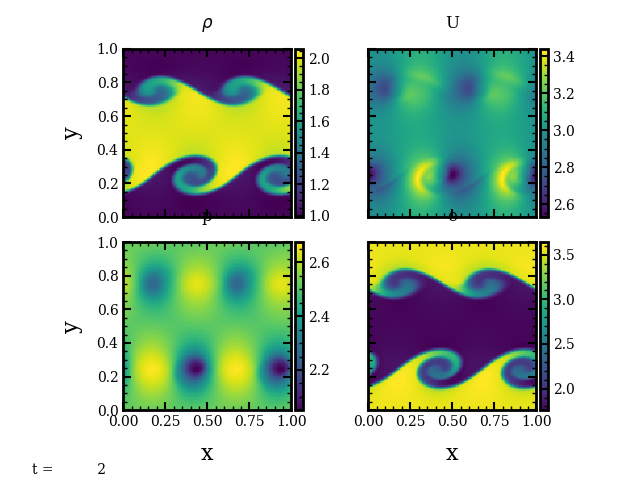

Simulation for bulk velcoity = 3.0 km/s using compressible_rk done.


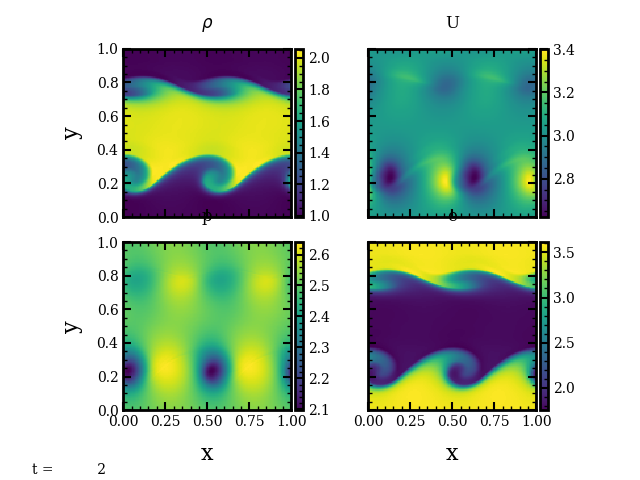

Simulation for bulk velcoity = 3.0 km/s using compressible_fv4 done.


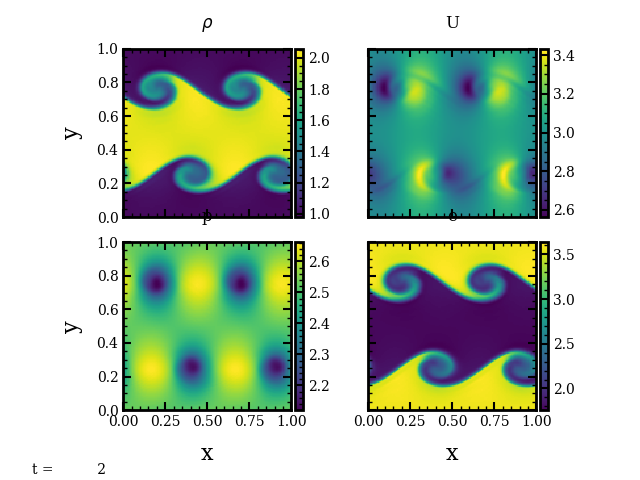

warning, key: compressible.limiter not defined
Simulation for bulk velcoity = 3.0 km/s using compressible_sdc done.


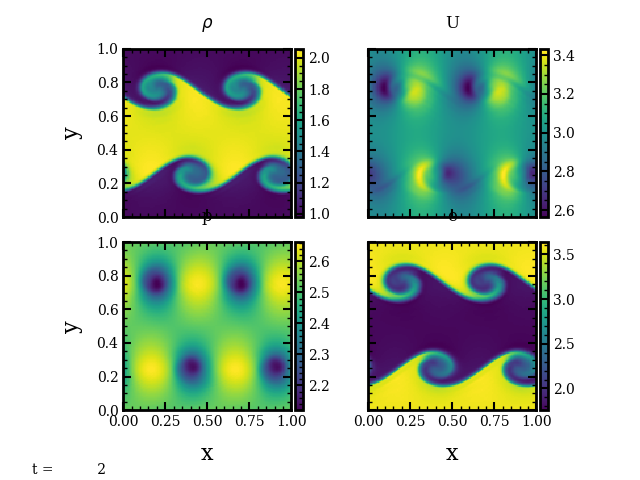

Simulation for bulk velcoity = 10.0 km/s using compressible done.


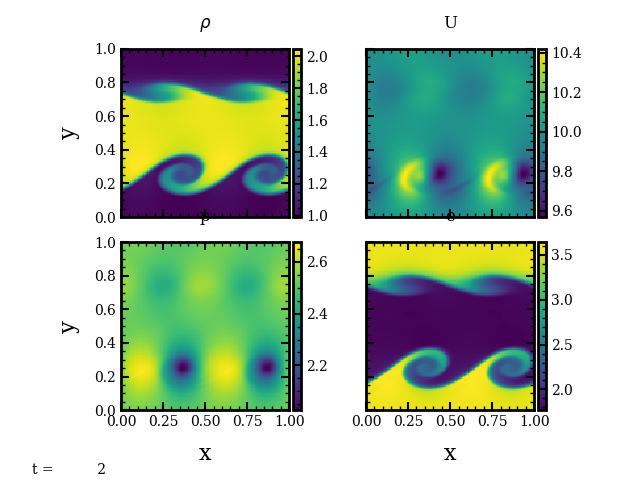

Simulation for bulk velcoity = 10.0 km/s using compressible_rk done.


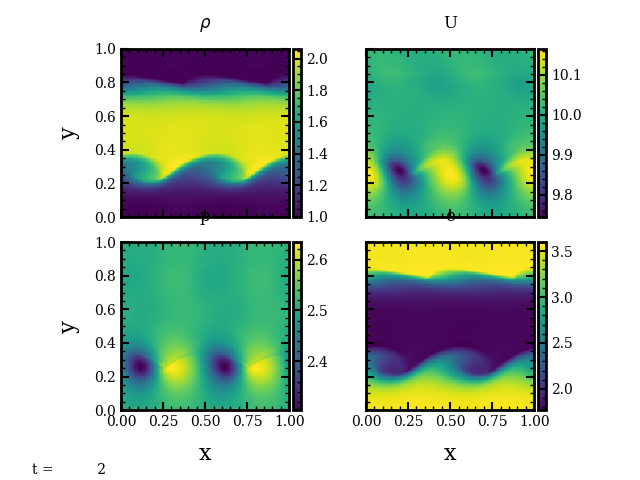

Simulation for bulk velcoity = 10.0 km/s using compressible_fv4 done.


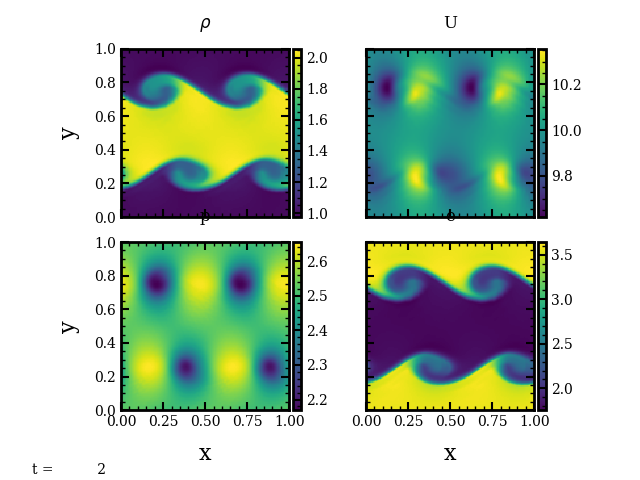

warning, key: compressible.limiter not defined
Simulation for bulk velcoity = 10.0 km/s using compressible_sdc done.


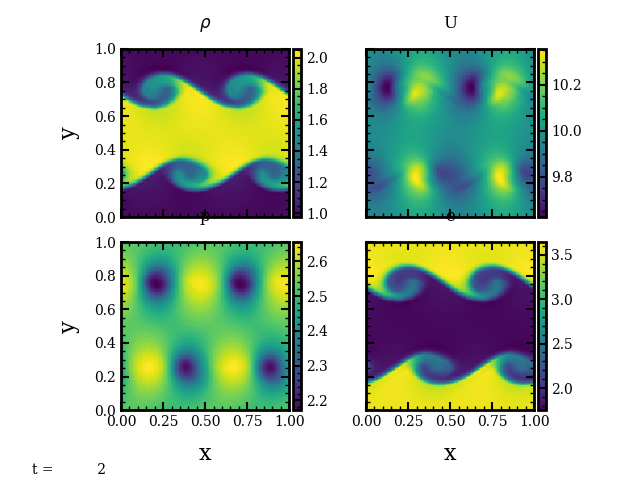

In [9]:
# reproduce plots 

from pyro import Pyro

first_solvers = ["compressible", "compressible_rk", "compressible_fv4", "compressible_sdc"] # solvers to be tested
first_problem_name = "kh"
first_param_file = "inputs.kh"

delta_u_values = [0.0, 1.0, 3.0, 10.0] # bulk velocities in km/s

for delta_u in delta_u_values:

    for solver in first_solvers:
        extra_parameters = {
            'eos.gamma': 1.7,
            'driver.tmax': 2.0,
            'kh.bulk_velocity': delta_u,
            'mesh.nx': 128,
            'mesh.ny': 128
        }

        pyro_sim = Pyro(solver)
        pyro_sim.initialize_problem(first_problem_name, inputs_file=first_param_file, inputs_dict=extra_parameters)

        pyro_sim.run_sim()

        print(f"Simulation for bulk velcoity = {delta_u} km/s using {solver} done.")

        # Create a new figure and save it
        pyro_sim.sim.dovis()
        plt.savefig(f"original_plots/plot_{solver}_deltaU{int(delta_u)}.png", bbox_inches='tight')
        plt.close()  


relative_velocities/Simulation for ΔU = 1.0 km/s using compressible done.


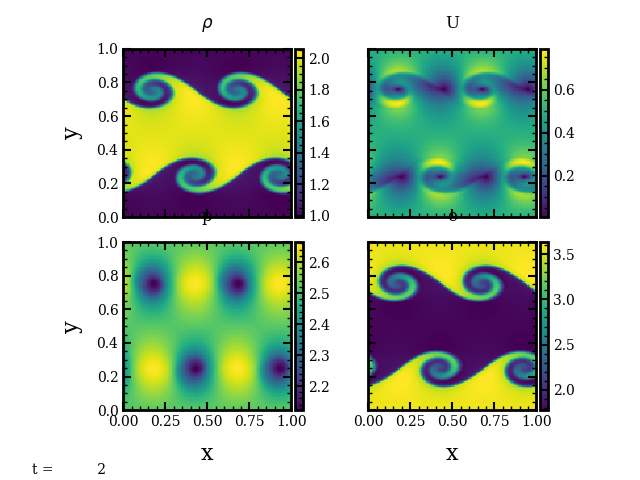

relative_velocities/Simulation for ΔU = 1.0 km/s using compressible_rk done.


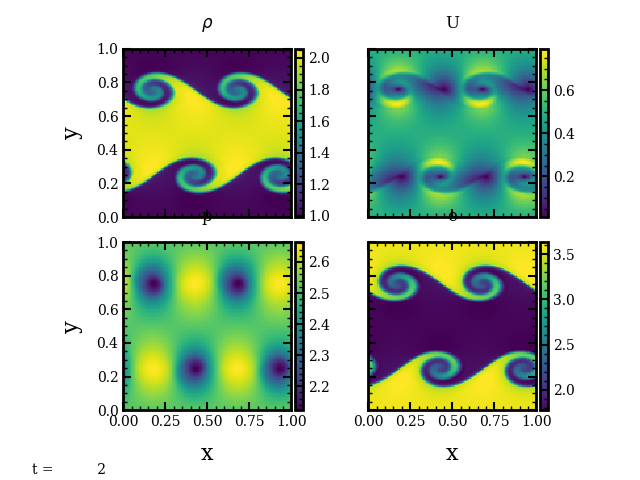

relative_velocities/Simulation for ΔU = 1.0 km/s using compressible_fv4 done.


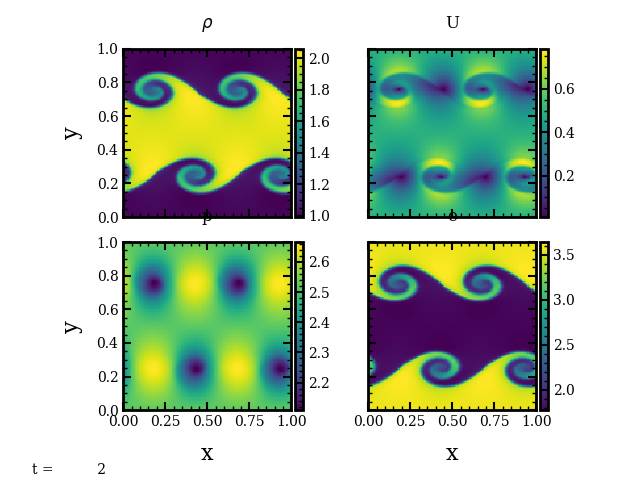

warning, key: compressible.limiter not defined
relative_velocities/Simulation for ΔU = 1.0 km/s using compressible_sdc done.


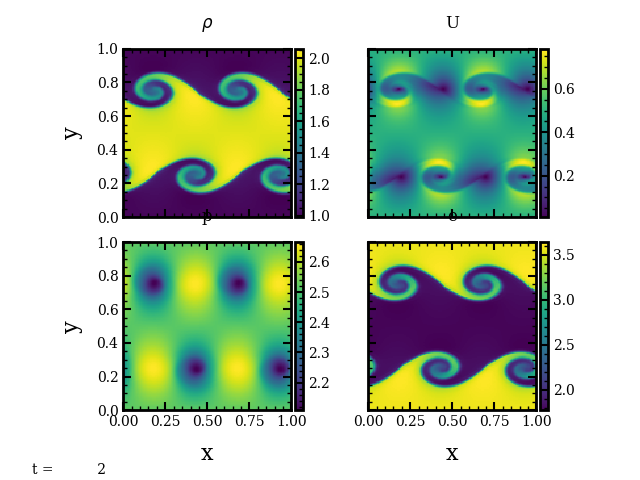

relative_velocities/Simulation for ΔU = 10.0 km/s using compressible done.


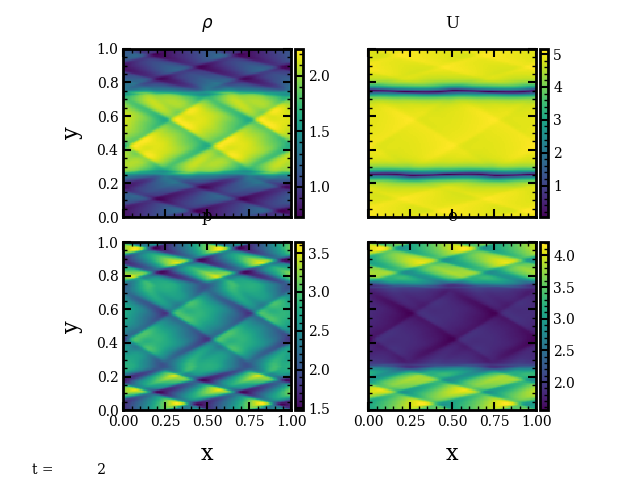

relative_velocities/Simulation for ΔU = 10.0 km/s using compressible_rk done.


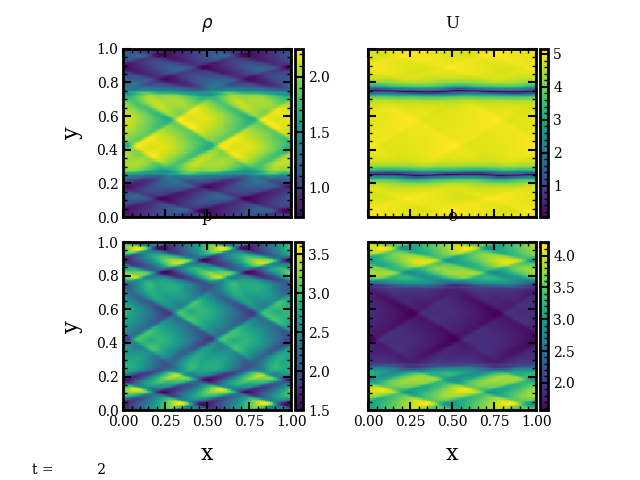

relative_velocities/Simulation for ΔU = 10.0 km/s using compressible_fv4 done.


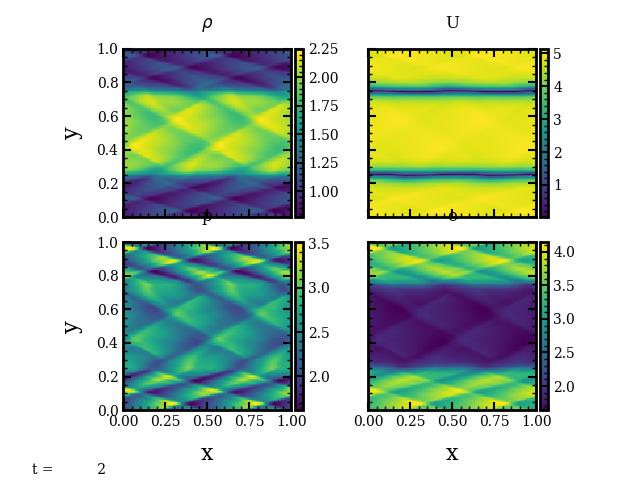

warning, key: compressible.limiter not defined
relative_velocities/Simulation for ΔU = 10.0 km/s using compressible_sdc done.


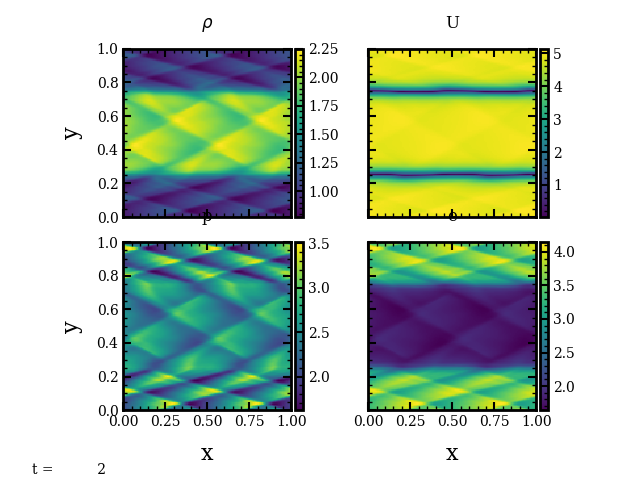

In [8]:
# tweak u1, u2

from pyro import Pyro

first_solvers = ["compressible", "compressible_rk", "compressible_fv4", "compressible_sdc"] # solvers to be tested
first_problem_name = "kh"
first_param_file = "inputs.kh"

delta_u_values = [1.0, 10.0] # relative velocities in km/s

for delta_u in delta_u_values:
    u_1 = -delta_u / 2.0
    u_2 = delta_u / 2.0

    for solver in first_solvers:
        extra_parameters = {
            'eos.gamma': 1.7,
            'driver.tmax': 2.0,
            'kh.u_1': u_1,
            'kh.u_2': u_2,
            'mesh.nx': 128,
            'mesh.ny': 128
        }

        pyro_sim = Pyro(solver)
        pyro_sim.initialize_problem(first_problem_name, inputs_file=first_param_file, inputs_dict=extra_parameters)

        pyro_sim.run_sim()

        print(f"Simulation for ΔU = {delta_u} km/s using {solver} done.")

        # Create a new figure and save it
        pyro_sim.sim.dovis()
        plt.savefig(f"relative_velocities/plot_{solver}_deltaU{int(delta_u)}.png", bbox_inches='tight')
        plt.close()  


The relative velocity of ±1 gives clear pictures of the KH instability, for all solvers. Things are getting different for the the u = ± 10 though. It seems that fv4 and sdc solvers are the best, since they reveal the most detail. But all of these outputs show a fuzzy behavior, rather than the instability, which is not what we would expect.  
There are two possible scenarios for the behavior we get in the high relative velocity case:
- One would expect that higher velocities would mean bigger instabilities, which is in principle correct, but it is also possible that if the relative velocity is so high, the two fluids will virtually not interact at all with each other, and will just continue flowing
- It is also possible that in the high relative velocity case, the velocities are so high that the Courant condition is not met anymore. Thus we don't have the right resolution to even visualize the instability (so the fuzzy picture we get is not correct physically, it is a numerical artifact).